In [1]:
import logging
from argparse import ArgumentParser
from multiprocessing import Pool
from pathlib import Path
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from laptrack import LapTrack
from skimage.measure import regionprops_table
from skimage.transform import downscale_local_mean

logging.basicConfig(level="INFO")



C:\Users\Nikon\Desktop\Code\Toettchlab-FBC\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def run_cellpose(infile, args):
    from cellpose import models
    from cellpose.io import imread

    model = models.CellposeModel(gpu=True, pretrained_model=args.model)

    stack = imread(infile)

    stack = [frame.astype(np.uint16) for frame in stack]

    if len(args.cellpose_norm) == 2:
        normalize = {"lowhigh": [args.cellpose_norm[0], args.cellpose_norm[1]]}

    else:
        normalize = True

    masks, _flows, _styles = model.eval(stack, batch_size=8, normalize=normalize)

    masks = np.stack(masks, axis=0)

    return masks


def process_masks(masks):
    collect_spots = []

    for t, frame in enumerate(masks):
        props = regionprops_table(frame, properties=["label", "area", "centroid"])

        df = pd.DataFrame(props)
        df["frame"] = t
        df = df.rename(columns={"centroid-0": "px_y", "centroid-1": "px_x"})

        print(df)

        collect_spots.append(df)

    spots_df = pd.concat([s for s in collect_spots], ignore_index=True)

    return spots_df


def track_spots(spots_df):
    max_distance = 20

    lt = LapTrack(
        metric="sqeuclidean",
        # The similarity metric for particles. See `scipy.spatial.distance.cdist` for allowed values.
        splitting_metric="sqeuclidean",
        merging_metric="sqeuclidean",
        gap_closing_metric="sqeuclidean",
        # the square of the cutoff distance for the "sqeuclidean" metric
        cutoff=max_distance**2,
        splitting_cutoff=False,  # or False for non-splitting case
        merging_cutoff=False,  # or False for non-merging case
        gap_closing_cutoff=max_distance**2,
        gap_closing_max_frame_count=2,
    )

    track_df, _split_df, _merge_df = lt.predict_dataframe(
        spots_df,
        coordinate_cols=[
            "px_x",
            "px_y",
        ],  # the column names for the coordinates
        frame_col="frame",  # the column name for the frame (default "frame")
        only_coordinate_cols=False,
    )

    track_df = track_df.rename(columns={"frame_y": "frame"})

    return track_df

def process_file(infile, in_dir, args):
    masks_dir = in_dir / "masks"
    tracks_dir = in_dir / "tracks"

    masks_outfile = masks_dir / f"{infile.stem}_masks.tif"
    tracks_outfile = tracks_dir / f"{infile.stem}_tracks.csv"

    cellpose_masks = run_cellpose(str(infile), args)
    tifffile.imwrite(
        masks_outfile,
        cellpose_masks.astype(np.uint16),
        imagej=True,
        metadata={"axes": "tyx"},
    )

    spots = process_masks(cellpose_masks)

    tracks = track_spots(spots)
    tracks.to_csv(tracks_outfile, index=False)

    return tracks

In [10]:
from types import SimpleNamespace

args = SimpleNamespace(
    dir = r"D:\Beena\input_for_seg_track",  # the folder containing the tifs
    glob = "*.tif",  # segments all the .tif files in a directory
    cellpose_norm = [500, 9500], # lowest and highest pixel intensities
    model = "BCL_model_001"  # name of the cellpose model to load
)

INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)


segmenting and tracking file 0/2: RTK78_6575


INFO:cellpose.models:>>>> loading model C:\Users\Nikon\.cellpose\models\BCL_model_001
INFO:cellpose.io:reading tiff with 11 planes
INFO:cellpose.models:0%|          | 0/11 [00:00<?, ?it/s]
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.models:100%|####

     label   area        px_y        px_x  frame
0        1  271.0    7.675277  136.214022      0
1        2  288.0    5.854167  163.677083      0
2        3  141.0    2.276596  276.255319      0
3        4  261.0   13.229885  454.854406      0
4        5  257.0   22.202335  147.027237      0
..     ...    ...         ...         ...    ...
147    148  175.0  498.434286    3.622857      0
148    149  311.0  497.704180  336.180064      0
149    150   91.0  508.472527   24.538462      0
150    151   98.0  508.744898  246.612245      0
151    152   21.0  510.523810  202.238095      0

[152 rows x 5 columns]
     label   area        px_y        px_x  frame
0        1   41.0    2.390244  131.829268      1
1        2  207.0    8.178744  137.565217      1
2        3  285.0    5.771930  162.178947      1
3        4  149.0    2.711409  275.476510      1
4        5  269.0   11.576208  455.869888      1
..     ...    ...         ...         ...    ...
147    148  298.0  498.969799  337.708054    

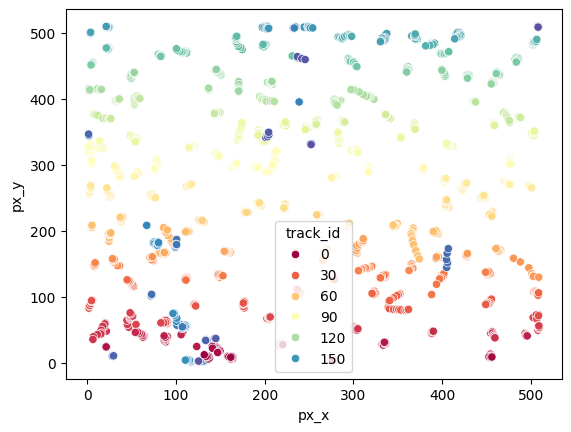

INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)


segmenting and tracking file 1/2: pPF050_7080


INFO:cellpose.models:>>>> loading model C:\Users\Nikon\.cellpose\models\BCL_model_001
INFO:cellpose.io:reading tiff with 11 planes
INFO:cellpose.models:0%|          | 0/11 [00:00<?, ?it/s]
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.transforms:processing grayscale image with (512, 512) HW
INFO:cellpose.models:100%|####

     label   area        px_y        px_x  frame
0        1  154.0    6.370130   11.909091      0
1        2  231.0    5.380952  183.142857      0
2        3  219.0    7.009132  204.643836      0
3        4  121.0    3.289256  281.876033      0
4        5  193.0    5.948187  402.414508      0
..     ...    ...         ...         ...    ...
281    282  186.0  506.403226   78.198925      0
282    283  218.0  505.926606  334.660550      0
283    284  231.0  506.722944  207.835498      0
284    285   71.0  509.323944  243.591549      0
285    286   77.0  509.662338   36.740260      0

[286 rows x 5 columns]
     label   area        px_y        px_x  frame
0        1  139.0    5.776978   11.561151      1
1        2  238.0    5.789916  183.336134      1
2        3  223.0    7.816143  204.708520      1
3        4  129.0    3.457364  281.395349      1
4        5  178.0    5.455056  451.589888      1
..     ...    ...         ...         ...    ...
276    277  121.0  504.033058  423.206612    

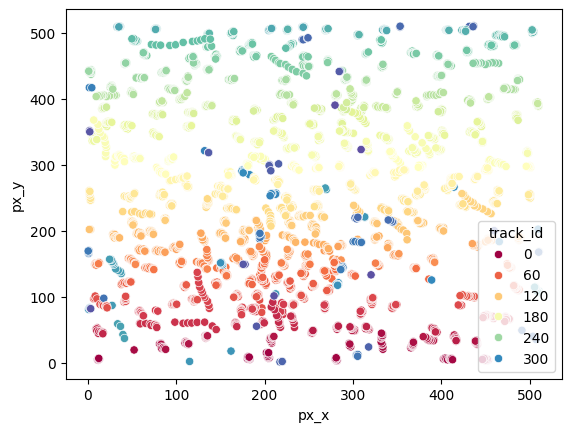

In [11]:

in_dir = Path(args.dir)

masks_dir = in_dir / "masks"
tracks_dir = in_dir / "tracks"

masks_dir.mkdir(exist_ok=True)
tracks_dir.mkdir(exist_ok=True)

files = list(in_dir.glob(args.glob))
shuffle(files)

for i, file in enumerate(files):
    print(f"segmenting and tracking file {i}/{len(files)}: {file.stem}")
    tracks = process_file(file, in_dir, args)

    import seaborn as sns

    sns.scatterplot(tracks, x="px_x", y="px_y", hue="track_id", palette="Spectral")
    plt.show()

